In [1]:
from imports import *
from read_data import *
from priors import *
from bgls import *
from autocorrDFM import *
from periodogram import compute_LSperiodogram
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [55]:
# get data
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS()
t0 = bjd.min()

# remove bad points
g = np.delete(np.arange(bjd.size), np.array([10,48]))
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = \
bjd[g],rv[g],erv[g],fwhm[g],bis[g],Halpha[g],eHalpha[g],Hbeta[g],eHbeta[g],Hgamma[g],eHgamma[g],NaD[g],eNaD[g],Sindex[g],eSindex[g]
print bjd.size

-5678.16
112


<Container object of 3 artists>

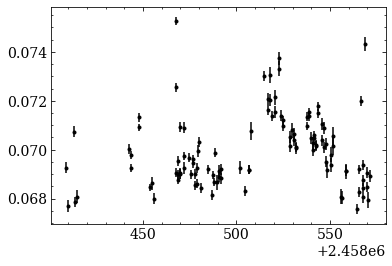

In [57]:
# plot Halpha
plt.errorbar(bjd, Halpha, eHalpha, fmt='k.')

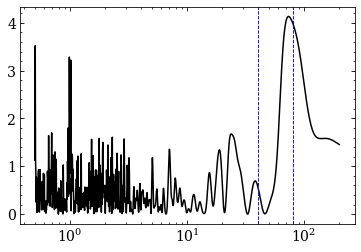

In [102]:
# periodogram
Prot = 80.
per,_,pwr = compute_LSperiodogram(bjd, Halpha, eHalpha, plims=(.5,2e2))
plt.plot(per, pwr, 'k-'), plt.xscale('log')
for p in [Prot,Prot/2.]:
    plt.axvline(p, ls='--', lw=.9, color='b')

In [59]:
def get_model(thetaGP, bjd, y, ey):
    a, l, G, P = np.exp(thetaGP[:4])
    s = thetaGP[4]
    k1 = george.kernels.ExpSquaredKernel(l)
    k2 = george.kernels.ExpSine2Kernel(G,P)
    gp = george.GP(a*k1*k2)
    try:
        gp.compute(bjd, np.sqrt(ey**2 + s**2))
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf
    mu, cov = gp.predict(y, bjd)
    sig = np.sqrt(np.diag(cov))
    return gp, mu, sig

In [60]:
def lnlike(thetaGP, bjd, Halpha, eHalpha):
    gp,_,_ = get_model(thetaGP, bjd, Halpha, eHalpha)
    return gp.lnlikelihood(Halpha, quiet=True)

In [125]:
def lnprior(thetaGP):
    lna, lnl, lnG, lnP, s = thetaGP
    lps = np.zeros(5)
    lps[0] = lnuniform(lna, -10, -2)
    lps[1] = lnuniform(lnl, 1, 20)
    lps[2] = lnuniform(lnG, -10, 10)
    lps[3] = lnuniform(lnP, 2, 5)
    lps[4] = lnjeffreysprior(s, 1e-6, 1e-3)
    return lps.sum()

In [126]:
def lnprob(thetaGP, bjd, Halpha, eHalpha):
    lp = lnprior(thetaGP)
    if np.isfinite(lp):
        return lp + lnlike(thetaGP, bjd, Halpha, eHalpha)
    else:
        return -np.inf

In [127]:
def run_emcee(thetaGP, bjd, Halpha, eHalpha, initialize, nwalkers=100, burnin=300, nsteps=400, a=1.9):
    ndim, p0 = len(thetaGP), []
    assert len(initialize) == ndim
    for i in range(nwalkers):
        p0.append(thetaGP + initialize*np.random.randn(ndim))
        
    args = (bjd, Halpha, eHalpha)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args, a=a)
    
    print '\nRunning Burnin (training set)...'
    t0 = time.time()
    p0,_,_ = sampler.run_mcmc(p0, burnin)
    print 'Burnin acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Burnin took %.4f minutes\n'%((time.time()-t0)/60.)
    sampler.reset()
    
    print 'Running MCMC (training set)...'
    p0,_,_ = sampler.run_mcmc(p0, nsteps)
    print "Mean acceptance fraction: %.4f"%np.mean(sampler.acceptance_fraction)
    print 'Full MCMC took %.4f minutes'%((time.time()-t0)/60.)
    samples = sampler.chain.reshape((-1, ndim))
    results = get_results(samples)
    
    return sampler, samples, results

In [128]:
# run mcmc on HARPS Halpha
thetaGP = np.log(1e-2), 10, 2, np.log(80), 1e-5
initialize = 1e-1, 1e-1, 1e-1, 1e-1, 1e-6

sampler, samples, results = run_emcee(thetaGP, bjd, Halpha, eHalpha, initialize)


Running Burnin (training set)...
Burnin acceptance fraction is 0.1368
Burnin took 1.1239 minutes

Running MCMC (training set)...
Mean acceptance fraction: 0.2713
Full MCMC took 2.5487 minutes


In [129]:
tau, Nsteps = autocorr_time_DFM(sampler.chain)
print '10 auto-correlation times = %.3f'%(tau*10)
print 'Actual length of chains = %i (i.e. %.2f auto-correlation times)'%(Nsteps,Nsteps/tau)

10 auto-correlation times = 483.346
Actual length of chains = 400 (i.e. 8.28 auto-correlation times)


In [130]:
# save
np.save('output_data/GPsamples_Halphav3', samples)

## plot results

In [139]:
samples = np.loadtxt('output_data/GPsamples_Halpha.dat')
results = get_results(samples)

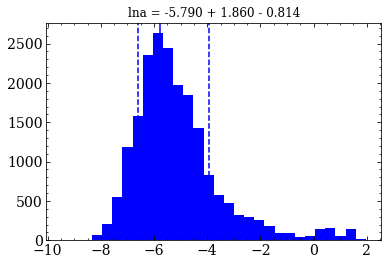

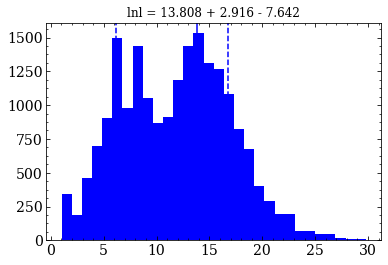

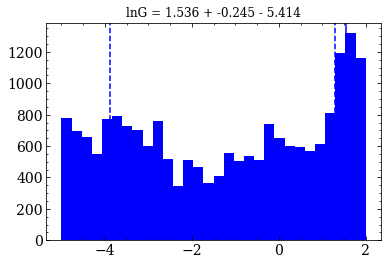

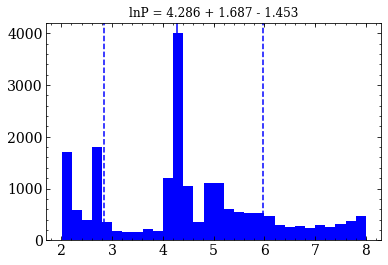

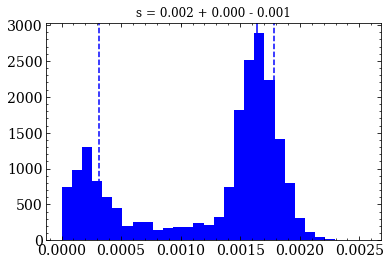

In [140]:
labels = ['lna','lnl','lnG','lnP','s']
g = np.arange(samples.shape[0])
#g = samples[:,2] >= 3
for i in range(samples.shape[1]):
    plt.figure(i)
    plt.hist(samples[g,i], bins=30)
    m,ps,ms = results[:,i]
    plt.axvline(m), plt.axvline(m-ms,ls='--'), plt.axvline(m+ps,ls='--')
    plt.title('%s = %.3f + %.3f - %.3f'%(labels[i],m,ps,ms))

Text(0.5,0,u'Time [BJD - 2458408]')

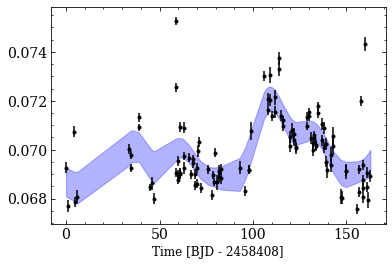

In [141]:
# get model
resultsGP = np.copy(results[0])
resultsGP[2] = -1.8
_,mu,sig = get_model(resultsGP, bjd, Halpha, eHalpha)

plt.errorbar(bjd-t0, Halpha, eHalpha, fmt='k.')
plt.fill_between(bjd-t0, mu-sig, mu+sig, color='b', alpha=.3)
plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)

([<matplotlib.lines.Line2D at 0x123e1cc90>], None)

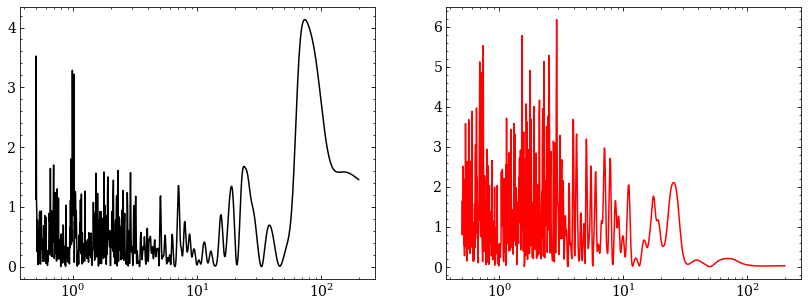

In [142]:
#periodograms
#per, pwr = bgls(bjd, Halpha, eHalpha, plow=.5, phigh=2e2, n_steps=1e3)
#per2, pwr2 = bgls(bjd, Halpha-mu, eHalpha, plow=.5, phigh=2e2, n_steps=1e3)
per,_,pwr = compute_LSperiodogram(bjd, Halpha, eHalpha, plims=(.5,2e2))
per2,_,pwr2 = compute_LSperiodogram(bjd, Halpha-mu, eHalpha, plims=(.5,2e2))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(per, pwr, 'k-'), plt.xscale('log')
plt.subplot(122)
plt.plot(per2, pwr2, 'r-'), plt.xscale('log')